In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA


In [3]:
# You can replace this path with your CSV file
df = pd.read_csv("C:/Users/harsh/Downloads/breast-cancer.csv")  # Use your own file path
df.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Drop ID column
df.drop(['id'], axis=1, inplace=True)

# Encode diagnosis (M = 1, B = 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Separate features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [6]:
svc_linear = SVC(kernel='linear', C=1)
svc_linear.fit(X_train, y_train)
y_pred_linear = svc_linear.predict(X_test)

print("Linear Kernel Results:")
print(confusion_matrix(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))


Linear Kernel Results:
[[68  3]
 [ 2 41]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [7]:
svc_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svc_rbf.fit(X_train, y_train)
y_pred_rbf = svc_rbf.predict(X_test)

print("RBF Kernel Results:")
print(confusion_matrix(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))


RBF Kernel Results:
[[70  1]
 [ 2 41]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [8]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=5)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9736263736263737


In [9]:
scores = cross_val_score(grid.best_estimator_, X_scaled, y, cv=5)
print("Cross-validation Accuracy: %.2f%%" % (scores.mean()*100))


Cross-validation Accuracy: 97.36%


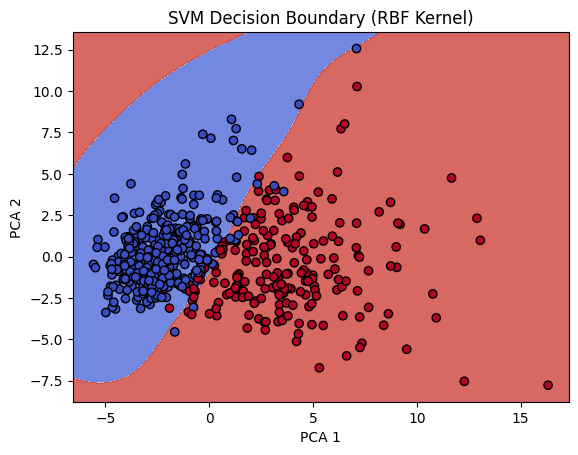

In [10]:
# Reduce data to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Retrain model for visualization
svc_vis = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
svc_vis.fit(X_pca, y)

# Plot decision boundary
def plot_decision_boundary(X, y, model):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('SVM Decision Boundary (RBF Kernel)')
    plt.show()

plot_decision_boundary(X_pca, y, svc_vis)
